In [2]:
# You will find the following 4 files:
# b2b_gv_vartojimas.xlsx - B2B prosumers
# b2b_ngv_vartojimas.xlsx - B2B consumers
# b2c_gv_vartojimas.xlsx - B2C prosumers
# b2c_ngv_vartojimas.xlsx - B2C consumers
# The goal is to create the most accurate models to predict the next day's (D-1) electricity consumption (24 values). 
# You should create a model that makes the forecast of each hour for the next day at 11:00 a.m. of the current day, because that's 
# how the market works - by 11:00 a.m. you need to provide the Nordpool operator with the volumes of electricity (and prices, but it 
# doesn't matter in this case) that you want to buy every hour the next day.

# An additional task is to create a classifier that allows to classify users as accurately as possible according to their electricity consumption data: 
# 4 classes according to the names of the excel files.

In [3]:
# 2025-01-16

# Užduotis - paskaičiuoti geriausio modelio spėjimo įverčius (R2 score, etc),
# lyginannt spėjimą su NordPool faktu.

# Užduotis - parašyti skriptą, kuris pateiktų prognozę tiesiog skaičiuodamas 
# vidutines vertes (pagal vidurkius)

# Palyginkite šio skripto prognozės tikslumą su dviem savo geriausiais modeliais 
# (pagal koreliacijos koef, R2 score, MAE, MSE, RMSE ...)

In [1]:
# Perskaičiavimo formulė: y = prognoze/0.00825/1e3
print(1/0.00825/1e3, 1e-3/0.00825, 1/8.25)

0.1212121212121212 0.12121212121212122 0.12121212121212122


In [1]:
from datetime import datetime as dt
import os 
import pandas as pd
import numpy as np

data_dir="../../../duomenys/elektros_paklausa/"
data_file_ext="xlsx"

weekday_names=["Pirmadienis","Antradienis","Trečiadienis","Ketvirtadienis","Penktadienis","Šeštadienis","Sekmadienis"]
data_files=['b2b_gv_vartojimas','b2c_gv_vartojimas','b2c_ngv_vartojimas','b2b_ngv_vartojimas']
date_cols=['data_valanda','dateTime','dateTime','data_valanda']

print('Paskaita. Pasiruošta',dt.now().replace(microsecond=0))
print(os.listdir(data_dir))

Paskaita. Pasiruošta 2025-01-20 17:46:39
['b2b_gv_vartojimas.xlsx', 'b2b_ngv_vartojimas.xlsx', 'b2c_gv_vartojimas.xlsx', 'b2c_ngv_vartojimas.xlsx', 'ML_Nordpool.docx', 'REGRESIJOS.pdf', 'Uzduotis.txt']


In [2]:
print("Duomenys iš failų įkeliami į 'df_dict={}'. ",dt.now().replace(microsecond=0))

df_dict={}

# for index, file in enumerate(data_files): 
for file in data_files:

    # pip install openpyxl
    print(f'{data_dir}{file}.{data_file_ext}',end=' ')
    df = pd.read_excel(f'{data_dir}{file}.{data_file_ext}')

    # Skaičiuojame visų skaitmeninių stulpelių sumą
    df["sum"] = df.select_dtypes(include=np.number).sum(axis=1)

    # Ištriname skaitmeninius stulpelius
    df.drop(columns=df.select_dtypes(include=np.number).columns[:-1], inplace=True)

    df['datetime'] = df.iloc[:,0] # Nulinis stulpelis, skirtingi pavadinimai.
    df.drop(df.columns[0], axis=1, inplace=True)

    df['month'] = df['datetime'].dt.month
    df['weekday'] = df['datetime'].dt.weekday
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    
    # Dienos ritmo kintamasis
    df['cos_hour'] = np.cos(2 * np.pi * df['hour'] % 24 / 24)
    # Valandų skaičius nuo pirmadienio 0:00 (savaitės ritmo kintamasis)
    df['weekhour'] = df['datetime'].dt.weekday * 24 + df['datetime'].dt.hour

    print(f'>>> {df.shape} (eil. x stulp.)')
    # print(df.head(1))

    df_dict[file]=df
    # df = df[['hour', 'cos_hour', 'air_temperature']]  # Pasirenkame reikiamus stulpelius
    # final_df = pd.concat([final_df, df], ignore_index=True)

Duomenys iš failų įkeliami į 'df_dict={}'.  2025-01-20 17:46:45
../../../duomenys/elektros_paklausa/b2b_gv_vartojimas.xlsx >>> (8760, 8) (eil. x stulp.)
../../../duomenys/elektros_paklausa/b2c_gv_vartojimas.xlsx >>> (2185, 8) (eil. x stulp.)
../../../duomenys/elektros_paklausa/b2c_ngv_vartojimas.xlsx >>> (2185, 8) (eil. x stulp.)
../../../duomenys/elektros_paklausa/b2b_ngv_vartojimas.xlsx >>> (8760, 8) (eil. x stulp.)


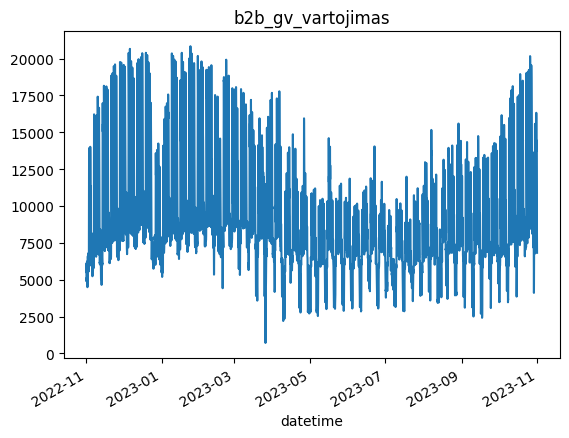

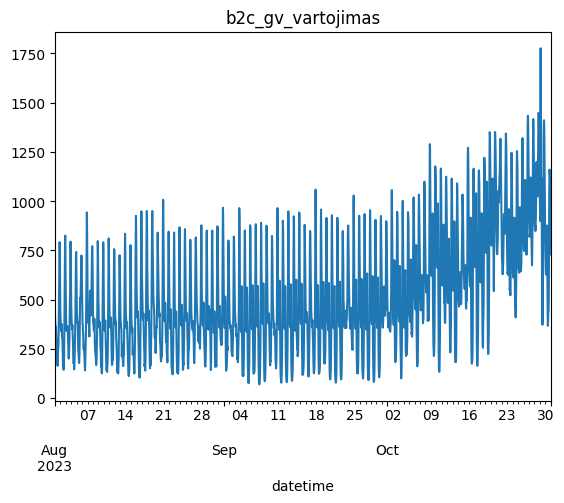

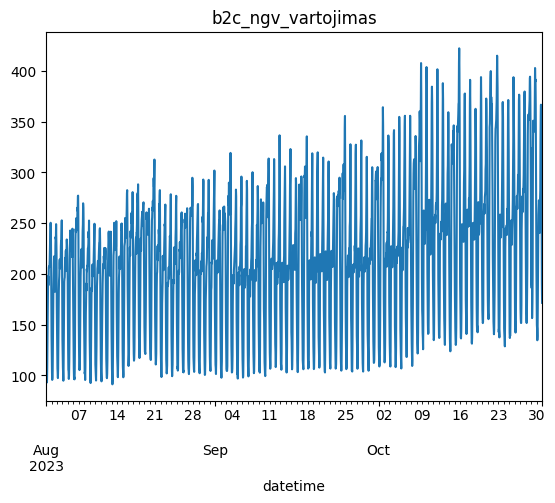

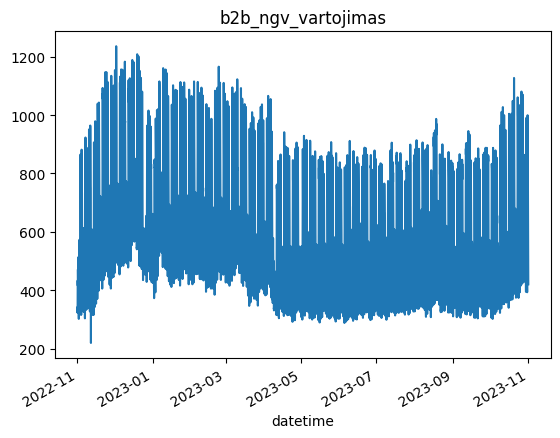

In [3]:
import matplotlib.pyplot as plt

# fig, ((b2b_gv_vartojimas,b2c_gv_vartojimas),(b2c_ngv_vartojimas,b2b_ngv_vartojimas)) \
#     = plt.subplots(2,2, figsize=(9,9), gridspec_kw={'width_ratios':[1,1], 'height_ratios':[1,1]})

for key, df in df_dict.items():
    fig, ax = plt.subplots()
    df.copy().set_index('datetime')['sum'].plot(ax=ax)
    ax.set_title(key)
    # print(key)

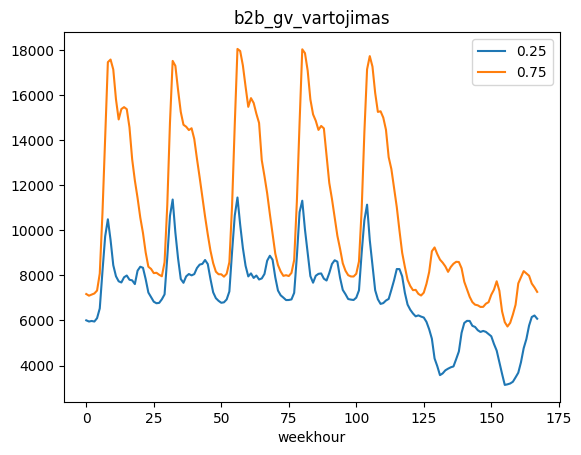

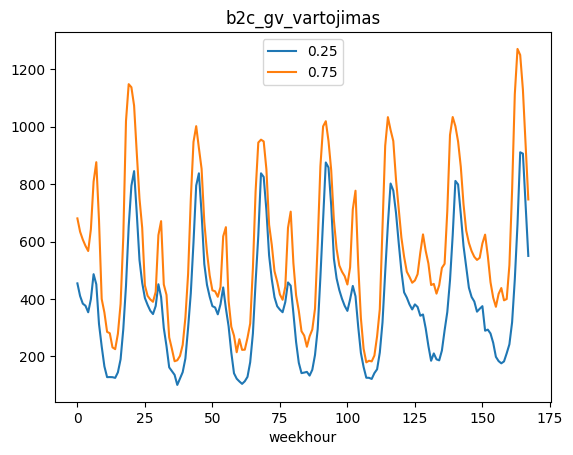

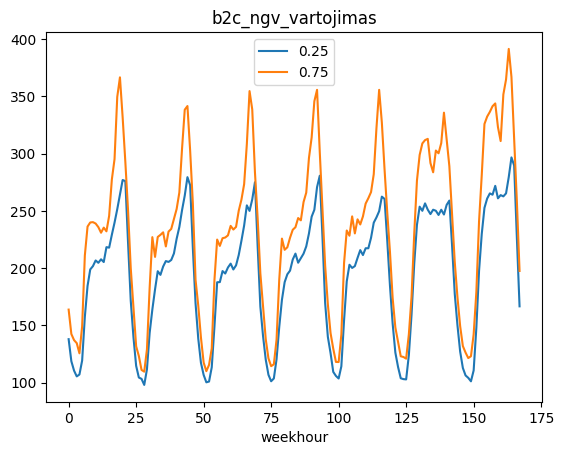

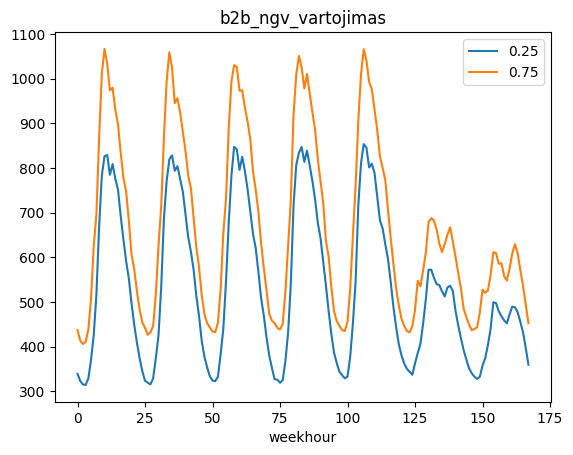

In [4]:
for key, df in df_dict.items():
    fig, ax = plt.subplots()
    
    quantiles = df.groupby(["weekhour"])['sum'].quantile([0.25, 0.75]).unstack()
    quantiles.copy().plot(ax=ax)
    ax.set_title(key)

In [5]:
df.groupby(["weekhour"]).quantile([0.25, 0.75]).unstack()

sum                        datetime                      \
                0.25        0.75                0.25                0.75   
weekhour                                                                   
0         338.960301  437.111205 2023-02-04 06:00:00 2023-08-01 18:00:00   
1         323.560916  413.671882 2023-02-04 07:00:00 2023-08-01 19:00:00   
2         315.501500  406.088092 2023-02-04 08:00:00 2023-08-01 20:00:00   
3         314.398318  410.485676 2023-02-04 09:00:00 2023-08-01 21:00:00   
4         328.526766  438.166113 2023-02-04 10:00:00 2023-08-01 22:00:00   
...              ...         ...                 ...                 ...   
163       477.240142  609.616380 2023-02-04 01:00:00 2023-08-01 13:00:00   
164       455.615491  571.358237 2023-02-04 02:00:00 2023-08-01 14:00:00   
165       432.224689  535.849244 2023-02-04 03:00:00 2023-08-01 15:00:00   
166       397.545789  494.399546 2023-02-04 04:00:00 2023-08-01 16:00:00   
167       359.434851  452.793235 2023-02-04 05:00:00 2023-08-01 17:00:00   

         month       weekday        day         hour        cos_hour            
          0.25  0.75    0.25 0.75  0.25   0.75  0.25  0.75      0.25      0.75  
weekhour                                                                        
0         3.75  9.25     0.0  0.0  8.75  23.25   0.0   0.0  1.000000  1.000000  
1         3.75  9.25     0.0  0.0  8.75  23.25   1.0   1.0  0.965926  0.965926  
2         3.75  9.25     0.0  0.0  8.75  23.25   2.0   2.0  0.866025  0.866025  
3         3.75  9.25     0.0  0.0  8.75  23.25   3.0   3.0  0.707107  0.707107  
4         3.75  9.25     0.0  0.0  8.75  23.25   4.0   4.0  0.998886  0.998886  
...        ...   ...     ...  ...   ...    ...   ...   ...       ...       ...  
163       3.75  9.25     6.0  6.0  8.00  23.00  19.0  19.0  0.561840  0.561840  
164       3.75  9.25     6.0  6.0  8.00  23.00  20.0  20.0  0.972284  0.972284  
165       3.75  9.25     6.0  6.0  8.00  23.00  21.0  21.0  0.878641  0.878641  
166       3.75  9.25     6.0  6.0  8.00  23.00  22.0  22.0  0.725121  0.725121  
167       3.75  9.25     6.0  6.0  8.00  23.00  23.0  23.0  0.999771  0.999771  

[168 rows x 14 columns]

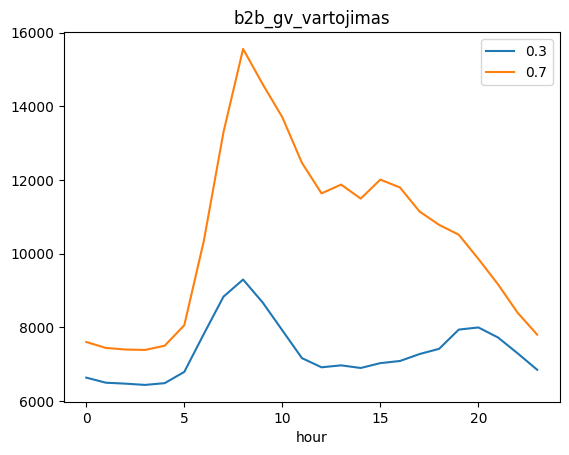

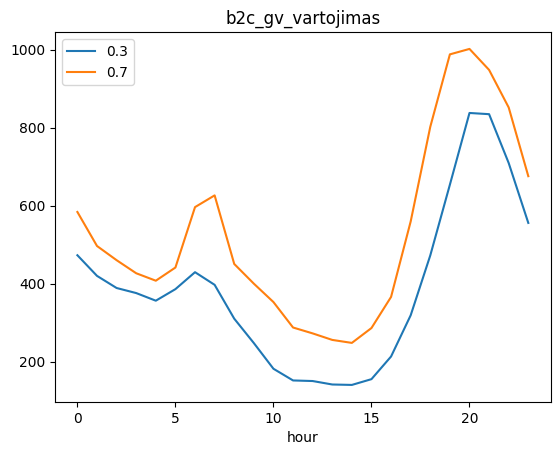

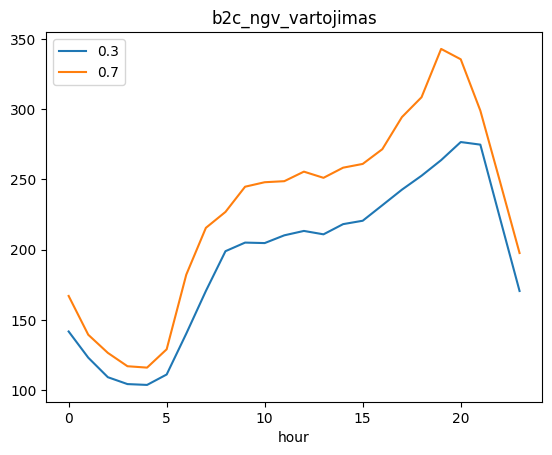

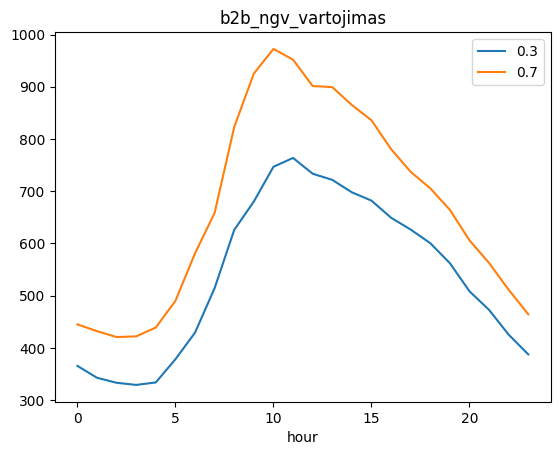

In [11]:
for key, df in df_dict.items():
    fig, ax = plt.subplots()
    
    quantiles = df.groupby(["hour"])['sum'].quantile([0.3, 0.7]).unstack()
    quantiles.copy().plot(ax=ax)
    ax.set_title(key)

In [4]:
###############################################################

import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [7]:
( b2b_gv, b2c_gv, b2c_ngv, b2b_ngv ) = df_dict

In [8]:
b2b_gv_learn = b2b_gv[:-48] # ; b2b_gv_learn
b2b_ngv_learn = b2b_ngv[:-48] # ; b2b_ngv_learn
b2c_gv_learn = b2c_gv[:-24] # ; b2c_gv_learn
b2c_ngv_learn = b2c_ngv[:-24] # ; b2c_ngv_learn

In [43]:
b2b_gv_learn['month'] = pd.to_datetime(b2b_gv_learn['data_valanda']).dt.month
b2b_gv_learn['week'] = pd.to_datetime(b2b_gv_learn['data_valanda']).dt.weekday
b2b_gv_learn['day'] = pd.to_datetime(b2b_gv_learn['data_valanda']).dt.day
b2b_gv_learn['hour'] = pd.to_datetime(b2b_gv_learn['data_valanda']).dt.hour

b2b_ngv_learn['month'] = pd.to_datetime(b2b_ngv_learn['data_valanda']).dt.month
b2b_ngv_learn['week'] = pd.to_datetime(b2b_ngv_learn['data_valanda']).dt.weekday
b2b_ngv_learn['day'] = pd.to_datetime(b2b_ngv_learn['data_valanda']).dt.day
b2b_ngv_learn['hour'] = pd.to_datetime(b2b_ngv_learn['data_valanda']).dt.hour

b2c_gv_learn['month'] = pd.to_datetime(b2c_gv_learn['dateTime']).dt.month
b2c_gv_learn['week'] = pd.to_datetime(b2c_gv_learn['dateTime']).dt.weekday
b2c_gv_learn['day'] = pd.to_datetime(b2c_gv_learn['dateTime']).dt.day
b2c_gv_learn['hour'] = pd.to_datetime(b2c_gv_learn['dateTime']).dt.hour

b2c_ngv_learn['month'] = pd.to_datetime(b2c_ngv_learn['dateTime']).dt.month
b2c_ngv_learn['week'] = pd.to_datetime(b2c_ngv_learn['dateTime']).dt.weekday
b2c_ngv_learn['day'] = pd.to_datetime(b2c_ngv_learn['dateTime']).dt.day
b2c_ngv_learn['hour'] = pd.to_datetime(b2c_ngv_learn['dateTime']).dt.hour

In [84]:
datefrom = datetime(2023,9,1,0)
dateto = datetime(2023,10,30,0)
b2b_gv_learn_filtered = b2b_gv_learn.query('data_valanda > @datefrom & data_valanda < @dateto')
b2b_ngv_learn_filtered = b2b_ngv_learn.query('data_valanda > @datefrom & data_valanda < @dateto')
b2c_gv_learn_filtered = b2c_gv_learn.query('dateTime > @datefrom & dateTime < @dateto')
b2c_ngv_learn_filtered = b2c_ngv_learn.query('dateTime > @datefrom & dateTime < @dateto')

In [85]:
columns_to_sum_b2bgv = b2b_gv_learn_filtered.drop(columns=['data_valanda', 'month', 'week', 'day', 'hour']).columns
columns_to_sum_b2bngv = b2b_ngv_learn_filtered.drop(columns=['data_valanda', 'month', 'week', 'day', 'hour']).columns
columns_to_sum_b2cgv = b2c_gv_learn_filtered.drop(columns=['dateTime', 'month', 'week', 'day', 'hour']).columns
columns_to_sum_b2cngv = b2c_ngv_learn_filtered.drop(columns=['dateTime', 'month', 'week', 'day', 'hour']).columns


In [86]:
b2b_gv_learn_filtered['viso'] = b2b_gv_learn_filtered[columns_to_sum_b2bgv].sum(axis=1)
b2b_ngv_learn_filtered['viso'] = b2b_ngv_learn_filtered[columns_to_sum_b2bngv].sum(axis=1)
b2c_gv_learn_filtered['viso'] = b2c_gv_learn_filtered[columns_to_sum_b2cgv].sum(axis=1)
b2c_ngv_learn_filtered['viso'] = b2c_ngv_learn_filtered[columns_to_sum_b2cngv].sum(axis=1)

In [27]:
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split, cross_val_score
from Skriptai.manofunkcijos import *
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeRegressor

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [87]:
X_b2bgv = b2b_gv_learn_filtered[['month', 'week', 'day', 'hour']]
y_b2bgv = b2b_gv_learn_filtered['viso']
X_b2bngv = b2b_ngv_learn_filtered[['month', 'week', 'day', 'hour']]
y_b2bngv = b2b_ngv_learn_filtered['viso']
X_b2cgv = b2c_gv_learn_filtered[['month', 'week', 'day', 'hour']]
y_b2cgv = b2c_gv_learn_filtered['viso']
X_b2cngv = b2c_ngv_learn_filtered[['month', 'week', 'day', 'hour']]
y_b2cngv = b2c_ngv_learn_filtered['viso']

In [88]:
X_train_b2bgv, X_test_b2bgv, y_train_b2bgv, y_test_b2bgv = train_test_split(X_b2bgv, y_b2bgv, test_size=0.20, random_state=23)
X_train_b2bngv, X_test_b2bngv, y_train_b2bngv, y_test_b2bngv = train_test_split(X_b2bngv, y_b2bngv, test_size=0.20, random_state=23)
X_train_b2cgv, X_test_b2cgv, y_train_b2cgv, y_test_b2cgv = train_test_split(X_b2cgv, y_b2cgv, test_size=0.20, random_state=23)
X_train_b2cngv, X_test_b2cngv, y_train_b2cngv, y_test_b2cngv = train_test_split(X_b2cngv, y_b2cngv, test_size=0.20, random_state=23)

In [89]:
linear_b2bgv = LinearRegression().fit(X_train_b2bgv, y_train_b2bgv)
pred_b2bgv = linear_b2bgv.predict(X_test_b2bgv)
print(f'b2b_gv linijinės vertinimas: {linear_b2bgv.score(X_test_b2bgv, y_test_b2bgv)*100.0}')
linear_b2bngv = LinearRegression().fit(X_train_b2bngv, y_train_b2bngv)
pred_b2bngv = linear_b2bngv.predict(X_test_b2bngv)
print(f'b2b_ngv linijinės vertinimas: {linear_b2bngv.score(X_test_b2bngv, y_test_b2bngv)*100.0}')
linear_b2cgv = LinearRegression().fit(X_train_b2cgv, y_train_b2cgv)
pred_b2cgv = linear_b2cgv.predict(X_test_b2cgv)
print(f'b2c_gv linijinės vertinimas: {linear_b2cgv.score(X_test_b2cgv, y_test_b2cgv)*100.0}')
linear_b2cngv = LinearRegression().fit(X_train_b2cngv, y_train_b2cngv)
pred_b2cngv = linear_b2cngv.predict(X_test_b2cngv)
print(f'b2c_ngv linijinės vertinimas: {linear_b2cngv.score(X_test_b2cngv, y_test_b2cngv)*100.0}')

b2b_gv linijinės vertinimas: 28.806417704626607
b2b_ngv linijinės vertinimas: 13.061907180281796
b2c_gv linijinės vertinimas: 45.60023124526309
b2c_ngv linijinės vertinimas: 59.533872878754465


In [90]:
decision_b2bgv = DecisionTreeRegressor(random_state = 0).fit(X_train_b2bgv, y_train_b2bgv)
pred_b2bgv = decision_b2bgv.predict(X_test_b2bgv)
print(f'b2b_gv Decision tree vertinimas: {decision_b2bgv.score(X_test_b2bgv, y_test_b2bgv)*100.0}')
decision_b2bngv = DecisionTreeRegressor(random_state = 0).fit(X_train_b2bngv, y_train_b2bngv)
pred_b2bngv = decision_b2bngv.predict(X_test_b2bngv)
print(f'b2b_ngv Decision tree vertinimas: {decision_b2bngv.score(X_test_b2bngv, y_test_b2bngv)*100.0}')
decision_b2cgv = DecisionTreeRegressor(random_state = 0).fit(X_train_b2cgv, y_train_b2cgv)
pred_b2cgv = decision_b2cgv.predict(X_test_b2cgv)
print(f'b2c_gv Decision tree vertinimas: {decision_b2cgv.score(X_test_b2cgv, y_test_b2cgv)*100.0}')
decision_b2cngv = DecisionTreeRegressor(random_state = 0).fit(X_train_b2cngv, y_train_b2cngv)
pred_b2cngv = decision_b2cngv.predict(X_test_b2cngv)
print(f'b2c_ngv Decision tree vertinimas: {decision_b2cngv.score(X_test_b2cngv, y_test_b2cngv)*100.0}')

b2b_gv Decision tree vertinimas: 96.54934403117102
b2b_ngv Decision tree vertinimas: 97.14862474216763
b2c_gv Decision tree vertinimas: 95.95151760160127
b2c_ngv Decision tree vertinimas: 96.75243572132386


In [26]:
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train, y_train)
pred = regressor.predict(X_test)
regressor.score(X_test, y_test)*100.0

94.89045483995227

In [ ]:
# Iki čia padaryta

In [91]:
random_b2bgv = RandomForestRegressor(n_estimators=1000, random_state=42).fit(X_train_b2bgv, y_train_b2bgv)
pred_b2bgv = random_b2bgv.predict(X_test_b2bgv)
print(f'b2b_gv Random forest vertinimas: {random_b2bgv.score(X_test_b2bgv, y_test_b2bgv)*100.0}')
random_b2bngv = RandomForestRegressor(n_estimators=1000, random_state=42).fit(X_train_b2bngv, y_train_b2bngv)
pred_b2bngv = random_b2bngv.predict(X_test_b2bngv)
print(f'b2b_ngv Random forest vertinimas: {random_b2bngv.score(X_test_b2bngv, y_test_b2bngv)*100.0}')
random_b2cgv = RandomForestRegressor(n_estimators=1000, random_state=42).fit(X_train_b2cgv, y_train_b2cgv)
pred_b2cgv = random_b2cgv.predict(X_test_b2cgv)
print(f'b2c_gv Random forest vertinimas: {random_b2cgv.score(X_test_b2cgv, y_test_b2cgv)*100.0}')
random_b2cngv = RandomForestRegressor(n_estimators=1000, random_state=42).fit(X_train_b2cngv, y_train_b2cngv)
pred_b2cngv = random_b2cngv.predict(X_test_b2cngv)
print(f'b2c_ngv Random forest vertinimas: {random_b2cngv.score(X_test_b2cngv, y_test_b2cngv)*100.0}')

b2b_gv Random forest vertinimas: 96.97281059627507
b2b_ngv Random forest vertinimas: 98.50367503461379
b2c_gv Random forest vertinimas: 97.71742680121214
b2c_ngv Random forest vertinimas: 98.18673187376096


In [31]:
model = RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model.score(X_test, y_test)*100.0

96.95266575937018

In [109]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Funkcija, kuri sukuria datetime intervalą
def generate_datetime_range(start, end, freq='H'):
    """
    Sukuria datetime objektų intervalą nuo `start` iki `end` su nurodytu dažniu.
    
    :param start: Pradžios data (datetime objektas arba string formatu 'YYYY-MM-DD HH:MM').
    :param end: Pabaigos data (datetime objektas arba string formatu 'YYYY-MM-DD HH:MM').
    :param freq: Dažnis (pvz., 'H' - valandoms, 'D' - dienoms).
    :return: Pandas DataFrame su datetime objektu ir išskirtais 'month', 'week', 'day', 'hour'.
    """
    date_range = pd.date_range(start=start, end=end, freq=freq)
    df = pd.DataFrame({'datetime': date_range})
    df['month'] = df['datetime'].dt.month
    df['week'] = df['datetime'].dt.isocalendar().week
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    return df

start_date = '2023-10-30 01:00'
end_date = '2023-10-31 00:00'

b2bgv = generate_datetime_range(start=start_date, end=end_date)
b2bngv = generate_datetime_range(start=start_date, end=end_date)
b2cgv = generate_datetime_range(start=start_date, end=end_date)
b2cngv = generate_datetime_range(start=start_date, end=end_date)

X_b2bgv = b2bgv[['month', 'week', 'day', 'hour']] 
X_b2bngv = b2bngv[['month', 'week', 'day', 'hour']]
X_b2cgv = b2cgv[['month', 'week', 'day', 'hour']]
X_b2cngv = b2cngv[['month', 'week', 'day', 'hour']] 


b2bgv['linear'] = linear_b2bgv.predict(X_b2bgv)
b2bngv['linear'] = linear_b2bngv.predict(X_b2bngv)
b2cgv['linear'] = linear_b2cgv.predict(X_b2cgv)
b2cngv['linear'] = linear_b2cngv.predict(X_b2cngv)

b2bgv['decision_tree'] = decision_b2bgv.predict(X_b2bgv)
b2bngv['decision_tree'] = decision_b2bngv.predict(X_b2bngv)
b2cgv['decision_tree'] = decision_b2cgv.predict(X_b2cgv)
b2cngv['decision_tree'] = decision_b2cngv.predict(X_b2cngv)

b2bgv['random_frorest'] = random_b2bgv.predict(X_b2bgv)
b2bngv['random_frorest'] = random_b2bngv.predict(X_b2bngv)
b2cgv['random_frorest'] = random_b2cgv.predict(X_b2cgv)
b2cngv['random_frorest'] = random_b2cngv.predict(X_b2cngv)




In [110]:
datefrom = datetime(2023,10,30,1)
dateto = datetime(2023,10,31,0)
b2b_gv_merge = b2b_gv.query('data_valanda > @datefrom & data_valanda < @dateto')
b2b_ngv_merge = b2b_ngv.query('data_valanda > @datefrom & data_valanda < @dateto')
b2c_gv_merge = b2c_gv.query('dateTime > @datefrom & dateTime < @dateto')
b2c_ngv_merge = b2c_ngv.query('dateTime > @datefrom & dateTime < @dateto')

In [111]:
columns_to_sum_b2bgv = b2b_gv_merge.drop(columns=['data_valanda']).columns
columns_to_sum_b2bngv = b2b_ngv_merge.drop(columns=['data_valanda']).columns
columns_to_sum_b2cgv = b2c_gv_merge.drop(columns=['dateTime']).columns
columns_to_sum_b2cngv = b2c_ngv_merge.drop(columns=['dateTime']).columns

In [112]:
b2b_gv_merge['faktas'] = b2b_gv_merge[columns_to_sum_b2bgv].sum(axis=1)
b2b_ngv_merge['faktas'] = b2b_ngv_merge[columns_to_sum_b2bngv].sum(axis=1)
b2c_gv_merge['faktas'] = b2c_gv_merge[columns_to_sum_b2cgv].sum(axis=1)
b2c_ngv_merge['faktas'] = b2c_ngv_merge[columns_to_sum_b2cngv].sum(axis=1)

In [113]:
b2b_gv_merge['datetime'] = b2b_gv_merge['data_valanda']
b2b_ngv_merge['datetime'] = b2b_ngv_merge['data_valanda']
b2c_gv_merge['datetime'] = b2c_gv_merge['dateTime']
b2c_ngv_merge['datetime'] = b2c_ngv_merge['dateTime']

In [114]:
b2b_gv_merge = b2b_gv_merge[['datetime', 'faktas']]
b2b_ngv_merge = b2b_ngv_merge[['datetime', 'faktas']]
b2c_gv_merge = b2c_gv_merge[['datetime', 'faktas']]
b2c_ngv_merge = b2c_ngv_merge[['datetime', 'faktas']]

In [115]:
b2bgv = pd.merge(b2bgv,b2b_gv_merge, on='datetime')
b2bngv = pd.merge(b2bngv,b2b_ngv_merge, on='datetime')
b2cgv = pd.merge(b2cgv,b2c_gv_merge, on='datetime')
b2cngv = pd.merge(b2cngv,b2c_ngv_merge, on='datetime')

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [116]:
b2bgv = b2bgv.drop(columns=['month', 'week', 'day', 'hour'])
b2bngv = b2bngv.drop(columns=['month', 'week', 'day', 'hour'])
b2cgv = b2cgv.drop(columns=['month', 'week', 'day', 'hour'])
b2cngv = b2cngv.drop(columns=['month', 'week', 'day', 'hour'])

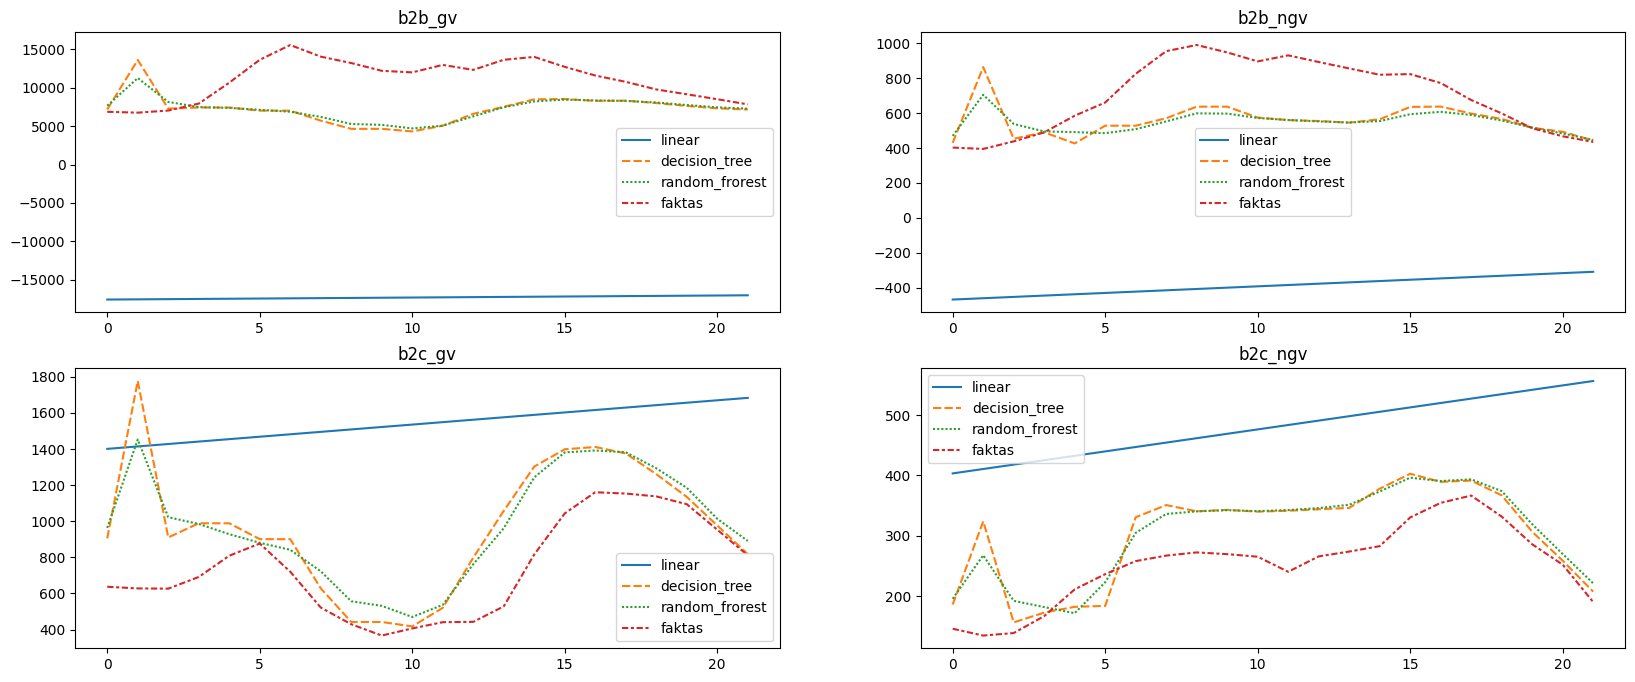

In [118]:
fig, axes = plt.subplots(2,2,figsize=(20,8))
axes[0,0].set_title(f'b2b_gv')
sns.lineplot(data=b2bgv,ax=axes[0,0])
axes[0,1].set_title(f'b2b_ngv')
sns.lineplot(data=b2bngv,ax=axes[0,1])
axes[1,0].set_title(f'b2c_gv')
sns.lineplot(data=b2cgv,ax=axes[1,0])
axes[1,1].set_title(f'b2c_ngv')
sns.lineplot(data=b2cngv,ax=axes[1,1])
plt.show()

In [ ]:
# Projektas
# Elektros energijos suvartojimo prognozė, atsižvelgiant į oro sąlygas
# Užduotis:
# Sukurti ir pateikti modelius, skirtus prognozuoti elektros energijos suvartojimą 24-rioms valandoms į
# priekį, atsižvelgiant į (prognozuojamas) oro sąlygas. Modeliams pateikus tikėtinas ateities oro sąlygas,
# modeliai turi pateikti 24-rių valandų energijos poreikio įvertinimą. Pradiniai testiniai duomenys: bet kuri
# diena tarp 2023-čių rugpjūčio 01 ir spalio 30-tos dienos. Vėliau išbandykite suprognozuoti elektros
# vartojimą realiai sekančiai dienai, ir palyginkite su Nordpool duomenimsi.prognoze.
# Istoriniai orų duomenys pasiekiami čia: https://archyvas.meteo.lt/
# Bendras LT energijos suvartojimas kas valandą pasiekiamas čia:
# https://data.nordpoolgroup.com/auction/day-ahead/volumes?deliveryDate=2025-01-
# 09&deliveryAreas=LT,AT
# Prognozuojami orai pasiekiami per meteo.lt API.
# Pritaikykite DecisionTreeRegressor, Linear, ectorMachinSupportVe, RandomForestRegressor.
# Papildomas punktas : SupportVectorMachine palaiko skirtingus kernel’ius duomenų fitinimui – linear,

# poly, rbf. Plačiau čia: https://www.geeksforgeeks.org/support-vector-regression-svr-using-linear-and-non-
# linear-kernels-in-scikit-learn/

# Išrinkite geriausią kernel’į SVR modeliui ir SVR modelio prognozes pateikite tik su geriausiu kernel’iu.
# Prieš pateikdami modelius, nustatykite, kokie parametrai turi daugiausiai įtakos prognozei (hint –
# koreliacijos matrica ir heatmap vizualizacija). Su pairplot pateikite atsirinktų parametrų tarpusavio
# priklausomybes.
# Pateikdami modelių prognozes, arba ieškodami geriausio modelio, geriausio kernel’io, taip pat pateikite
# jų įvertinimus (vidurkiai, standartiniai nuokrypiai, etc ... ).
# Pateikite modelių prognozes vizualizuodami jas.
# Papildomi reikalavimai:
# Sugeneruoti grafikai (vizualizacijos) turi būti automatiškai saugomi į projekto aplanką bei automatiškai
# dedami į docx failą.
# Matplotlib’o figūra gali būti saugojama į PNG su komanda .savefig().
# Plačiau čia: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
# Docx failo generavimas https://python-docx.readthedocs.io/en/latest/
# Duotoje nuorodoje pateikiamas minimalus veikiantis pavyzdys, kuriame sukuriamas Word docx
# dokumentas, į jį įterpiamas tekstas, paveikslai.
# https://data.nordpoolgroup.com/power-system/consumption?deliveryDate=2025-01-09&deliveryAreas=AT&aggregation=DeliveryPeriod

In [150]:
datefrom = datetime(2023,7,31,23)
dateto = datetime(2023,10,30,0)
b2b_gv_filtered = b2b_gv.query('data_valanda > @datefrom & data_valanda < @dateto')
b2b_ngv_filtered = b2b_ngv.query('data_valanda > @datefrom & data_valanda < @dateto')
b2c_gv_filtered = b2c_gv.query('dateTime > @datefrom & dateTime < @dateto')
b2c_ngv_filtered = b2c_ngv.query('dateTime > @datefrom & dateTime < @dateto')

In [151]:
columns_to_sum_b2bgv = b2b_gv_filtered.drop(columns=['data_valanda']).columns
columns_to_sum_b2bngv = b2b_ngv_filtered.drop(columns=['data_valanda']).columns
columns_to_sum_b2cgv = b2c_gv_filtered.drop(columns=['dateTime']).columns
columns_to_sum_b2cngv = b2c_ngv_filtered.drop(columns=['dateTime']).columns

In [152]:
b2b_gv_filtered['b2b_gv'] = b2b_gv_filtered[columns_to_sum_b2bgv].sum(axis=1)
b2b_ngv_filtered['b2b_ngv'] = b2b_ngv_filtered[columns_to_sum_b2bngv].sum(axis=1)
b2c_gv_filtered['b2c_gv'] = b2c_gv_filtered[columns_to_sum_b2cgv].sum(axis=1)
b2c_ngv_filtered['b2c_ngv'] = b2c_ngv_filtered[columns_to_sum_b2cngv].sum(axis=1)

In [153]:
b2b_gv_filtered['datetime'] = b2b_gv_filtered['data_valanda']
b2b_ngv_filtered['datetime'] = b2b_ngv_filtered['data_valanda']
b2c_gv_filtered['datetime'] = b2c_gv_filtered['dateTime']
b2c_ngv_filtered['datetime'] = b2c_ngv_filtered['dateTime']

In [154]:
b2b_gv_filtered = b2b_gv_filtered[['datetime', 'b2b_gv']]
b2b_ngv_filtered = b2b_ngv_filtered[['datetime', 'b2b_ngv']]
b2c_gv_filtered = b2c_gv_filtered[['datetime', 'b2c_gv']]
b2c_ngv_filtered = b2c_ngv_filtered[['datetime', 'b2c_ngv']]

In [243]:
gam_vart = pd.merge(b2b_gv_filtered,b2c_gv_filtered, on='datetime')
neg_vart = pd.merge(b2b_ngv_filtered,b2c_ngv_filtered, on='datetime')

In [137]:
gam_vart.columns

Index(['datetime', 'b2b_gv', 'b2c_gv'], dtype='object')

In [138]:
neg_vart.columns

Index(['datetime', 'b2b_ngv', 'b2c_ngv'], dtype='object')

In [244]:
gam_vart['Gaminantys'] = gam_vart[['b2b_gv', 'b2c_gv']].sum(axis=1)
neg_vart['Negaminantys'] = neg_vart[['b2b_ngv', 'b2c_ngv']].sum(axis=1)

In [245]:
gam_vart = gam_vart[['datetime','Gaminantys']]
neg_vart = neg_vart[['datetime','Negaminantys']]
df_for_learn = pd.merge(gam_vart,neg_vart, on='datetime')

In [246]:
df_for_learn['month'] = pd.to_datetime(df_for_learn['datetime']).dt.month
df_for_learn['week'] = pd.to_datetime(df_for_learn['datetime']).dt.weekday
df_for_learn['hour'] = pd.to_datetime(df_for_learn['datetime']).dt.hour

In [247]:
orai = pd.read_json('../../../weather_data_vilnius.json')

In [248]:
orai['datetime'] = pd.to_datetime(orai['obs_time_utc'])

In [164]:
orai

,obs_time_utc,station_code,air_temperature,feels_like_temperature,wind_speed,wind_gust,wind_direction,cloud_cover,sea_level_pressure,relative_humidity,precipitation,condition_code,datetime
0,2023-08-01 00:00:00,vilniaus-ams,14.8,14.8,2.1,3.2,165,25.0,1007.7,82,0.0,partly-cloudy,2023-08-01 00:00:00
1,2023-08-01 01:00:00,vilniaus-ams,13.8,13.8,1.5,2.6,150,25.0,1008.0,87,0.0,partly-cloudy,2023-08-01 01:00:00
2,2023-08-01 02:00:00,vilniaus-ams,13.6,13.6,1.7,2.8,142,50.0,1007.6,86,0.0,variable-cloudiness,2023-08-01 02:00:00
3,2023-08-01 03:00:00,vilniaus-ams,13.5,13.5,1.3,2.8,146,100.0,1007.5,87,0.0,cloudy,2023-08-01 03:00:00
4,2023-08-01 04:00:00,vilniaus-ams,15.0,15.0,1.6,2.9,142,0.0,1007.0,82,0.0,clear,2023-08-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2203,2023-10-31 19:00:00,vilniaus-ams,14.2,14.2,4.3,10.7,203,100.0,998.9,74,0.0,cloudy,2023-10-31 19:00:00
2204,2023-10-31 20:00:00,vilniaus-ams,13.7,13.7,3.6,7.0,191,100.0,999.1,79,0.0,cloudy,2023-10-31 20:00:00
2205,2023-10-31 21:00:00,vilniaus-ams,13.4,13.4,2.7,7.2,201,100.0,998.9,83,0.0,cloudy,2023-10-31 21:00:00
2206,2023-10-31 22:00:00,vilniaus-ams,12.1,12.1,2.2,4.7,188,88.0,998.8,88,0.0,cloudy,2023-10-31 22:00:00


In [249]:
orai_for_merge = orai[['datetime', 'air_temperature', 'wind_speed', 'cloud_cover']]

In [250]:
orai_for_merge = orai_for_merge.dropna(subset=['cloud_cover'])

In [220]:
orai_for_merge

,datetime,air_temperature,wind_speed,cloud_cover,cloud_coveris
0,2023-08-01 00:00:00,14.8,2.1,25.0,25.0
1,2023-08-01 01:00:00,13.8,1.5,25.0,25.0
2,2023-08-01 02:00:00,13.6,1.7,50.0,50.0
3,2023-08-01 03:00:00,13.5,1.3,100.0,100.0
4,2023-08-01 04:00:00,15.0,1.6,0.0,0.0
...,...,...,...,...,...
2203,2023-10-31 19:00:00,14.2,4.3,100.0,100.0
2204,2023-10-31 20:00:00,13.7,3.6,100.0,100.0
2205,2023-10-31 21:00:00,13.4,2.7,100.0,100.0
2206,2023-10-31 22:00:00,12.1,2.2,88.0,88.0


In [276]:
df_learn = pd.merge(df_for_learn,orai_for_merge, on='datetime')

In [252]:
df_learn

,datetime,Gaminantys,Negaminantys,month,week,hour,air_temperature,wind_speed,cloud_cover
0,2023-08-01 00:00:00,7017.462790,510.759334,8,1,0,14.8,2.1,25.0
1,2023-08-01 01:00:00,6830.855757,469.344333,8,1,1,13.8,1.5,25.0
2,2023-08-01 02:00:00,6681.877246,432.295334,8,1,2,13.6,1.7,50.0
3,2023-08-01 03:00:00,6604.817630,420.801000,8,1,3,13.5,1.3,100.0
4,2023-08-01 04:00:00,6875.745963,422.349333,8,1,4,15.0,1.6,0.0
...,...,...,...,...,...,...,...,...,...
2135,2023-10-29 19:00:00,9693.188468,988.985812,10,6,19,2.7,4.6,100.0
2136,2023-10-29 20:00:00,9270.997265,933.634510,10,6,20,4.2,5.6,100.0
2137,2023-10-29 21:00:00,8770.581333,823.117711,10,6,21,5.1,5.1,100.0
2138,2023-10-29 22:00:00,8294.118999,751.613663,10,6,22,6.0,5.0,100.0


In [277]:
X_gam = df_learn.drop(columns=['datetime', 'Gaminantys', 'Negaminantys'])
y_gam = df_learn['Gaminantys']
X_neg = df_learn.drop(columns=['datetime', 'Gaminantys', 'Negaminantys'])
y_neg = df_learn['Negaminantys']

In [278]:
df_learn

,datetime,Gaminantys,Negaminantys,month,week,hour,air_temperature,wind_speed,cloud_cover
0,2023-08-01 00:00:00,7017.462790,510.759334,8,1,0,14.8,2.1,25.0
1,2023-08-01 01:00:00,6830.855757,469.344333,8,1,1,13.8,1.5,25.0
2,2023-08-01 02:00:00,6681.877246,432.295334,8,1,2,13.6,1.7,50.0
3,2023-08-01 03:00:00,6604.817630,420.801000,8,1,3,13.5,1.3,100.0
4,2023-08-01 04:00:00,6875.745963,422.349333,8,1,4,15.0,1.6,0.0
...,...,...,...,...,...,...,...,...,...
2135,2023-10-29 19:00:00,9693.188468,988.985812,10,6,19,2.7,4.6,100.0
2136,2023-10-29 20:00:00,9270.997265,933.634510,10,6,20,4.2,5.6,100.0
2137,2023-10-29 21:00:00,8770.581333,823.117711,10,6,21,5.1,5.1,100.0
2138,2023-10-29 22:00:00,8294.118999,751.613663,10,6,22,6.0,5.0,100.0


In [279]:
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(X_neg, y_neg, test_size=0.20, random_state=23)
X_train_gam, X_test_gam, y_train_gam, y_test_gam = train_test_split(X_gam, y_gam, test_size=0.20, random_state=23)

In [280]:
decision_gam = DecisionTreeRegressor(random_state = 0).fit(X_train_gam, y_train_gam)
pred_gam = decision_gam.predict(X_test_gam)
print(f'Gaminančių vartotojų Decision tree vertinimas: {decision_b2bgv.score(X_test_b2bgv, y_test_b2bgv)*100.0}')
decision_neg = DecisionTreeRegressor(random_state = 0).fit(X_train_neg, y_train_neg)
pred_neg = decision_neg.predict(X_test_neg)
print(f'Negaminančių vartotojų Decision tree vertinimas: {decision_b2bngv.score(X_test_b2bngv, y_test_b2bngv)*100.0}')

Gaminančių vartotojų Decision tree vertinimas: 96.54934403117102
Negaminančių vartotojų Decision tree vertinimas: 97.14862474216763


In [281]:
from sklearn import svm
sv_gam = svm.SVR(kernel='linear')
sv_gam.fit(X_train_gam, y_train_gam)
pred_gam = sv_gam.predict(X_test_gam)
accuracy = sv_gam.score(X_test_gam, pred_gam)
print("Gaminančių vartotojų SVM linear", accuracy)
sv_neg = svm.SVR(kernel='linear').fit(X_train_neg, y_train_neg)
pred_neg = sv_gam.predict(X_test_neg)
accuracy = sv_gam.score(X_test_neg, pred_neg)
print("Negaminančių vartotojų SVM linear", accuracy)

Gaminančių vartotojų SVM linear 1.0
Negaminančių vartotojų SVM linear 1.0


In [282]:
from sklearn import svm
sv_gam_poly = svm.SVR(kernel='poly').fit(X_train_gam, y_train_gam)
pred_gam = sv_gam_poly.predict(X_test_gam)
accuracy = sv_gam_poly.score(X_test_gam, pred_gam)
print("Gaminančių vartotojų SVM Poly", accuracy)
sv_neg_poly = svm.SVR(kernel='poly').fit(X_train_neg, y_train_neg)
pred_neg = sv_gam_poly.predict(X_test_neg)
accuracy = sv_gam_poly.score(X_test_neg, pred_neg)
print("Negaminančių vartotojų SVM Poly", accuracy)

Gaminančių vartotojų SVM Poly 1.0
Negaminančių vartotojų SVM Poly 1.0


In [283]:
from sklearn import svm
sv_gam_rbf = svm.SVR(kernel='rbf').fit(X_train_gam, y_train_gam)
pred_gam = sv_gam_poly.predict(X_test_gam)
accuracy = sv_gam_poly.score(X_test_gam, pred_gam)
print("Gaminančių vartotojų SVM rbf", accuracy)
sv_neg_rbf = svm.SVR(kernel='rbf').fit(X_train_neg, y_train_neg)
pred_neg = sv_gam_poly.predict(X_test_neg)
accuracy = sv_gam_poly.score(X_test_neg, pred_neg)
print("Negaminančių vartotojų SVM rbf", accuracy)

Gaminančių vartotojų SVM rbf 1.0
Negaminančių vartotojų SVM rbf 1.0


In [284]:
random_gam = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_gam, y_train_gam)
pred_gam = random_gam.predict(X_test_gam)
print(f'Gaminančių vartotojų Random forest vertinimas: {random_gam.score(X_test_gam, y_test_gam)*100.0}')
random_neg = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_neg, y_train_neg)
pred_neg = random_neg.predict(X_test_neg)
print(f'Negaminančių vartotojų Random forest vertinimas: {random_neg.score(X_test_neg, y_test_neg)*100.0}')

Gaminančių vartotojų Random forest vertinimas: 88.68038311077038
Negaminančių vartotojų Random forest vertinimas: 97.25361213506496


In [285]:
linear_gam = LinearRegression().fit(X_train_gam, y_train_gam)
pred_gam = linear_gam.predict(X_test_gam)
print(f'Gaminančių vartotojų linijinės vertinimas: {linear_gam.score(X_test_gam, y_test_gam)*100.0}')
linear_neg = LinearRegression().fit(X_train_neg, y_train_neg)
pred_neg = linear_neg.predict(X_test_neg)
print(f'Negaminančių vartotojų linijinės vertinimas: {linear_neg.score(X_test_neg, y_test_neg)*100.0}')

Gaminančių vartotojų linijinės vertinimas: 30.573025488301553
Negaminančių vartotojų linijinės vertinimas: 36.48219540059604


In [288]:
start_date = '2023-10-30 00:00'
end_date = '2023-10-30 23:00'

gaminantys = generate_datetime_range(start=start_date, end=end_date)
negaminantys = generate_datetime_range(start=start_date, end=end_date)

gaminantys = pd.merge(gaminantys,orai_for_merge, on='datetime')
negaminantys = pd.merge(negaminantys,orai_for_merge, on='datetime')

# X_b2bgv = b2bgv[['month', 'week', 'day', 'hour']] 
# X_b2bngv = b2bngv[['month', 'week', 'day', 'hour']]
# X_b2cgv = b2cgv[['month', 'week', 'day', 'hour']]
# X_b2cngv = b2cngv[['month', 'week', 'day', 'hour']] 


# b2bgv['linear'] = linear_b2bgv.predict(X_b2bgv)
# b2bngv['linear'] = linear_b2bngv.predict(X_b2bngv)
# b2cgv['linear'] = linear_b2cgv.predict(X_b2cgv)
# b2cngv['linear'] = linear_b2cngv.predict(X_b2cngv)

# b2bgv['decision_tree'] = decision_b2bgv.predict(X_b2bgv)
# b2bngv['decision_tree'] = decision_b2bngv.predict(X_b2bngv)
# b2cgv['decision_tree'] = decision_b2cgv.predict(X_b2cgv)
# b2cngv['decision_tree'] = decision_b2cngv.predict(X_b2cngv)

# b2bgv['random_frorest'] = random_b2bgv.predict(X_b2bgv)
# b2bngv['random_frorest'] = random_b2bngv.predict(X_b2bngv)
# b2cgv['random_frorest'] = random_b2cgv.predict(X_b2cgv)
# b2cngv['random_frorest'] = random_b2cngv.predict(X_b2cngv)

In [289]:
gaminantys

,datetime,month,week,day,hour,air_temperature,wind_speed,cloud_cover
0,2023-10-30 00:00:00,10,44,30,0,7.0,3.6,88.0
1,2023-10-30 01:00:00,10,44,30,1,7.4,3.3,100.0
2,2023-10-30 02:00:00,10,44,30,2,7.9,3.4,100.0
3,2023-10-30 03:00:00,10,44,30,3,8.4,3.2,88.0
4,2023-10-30 04:00:00,10,44,30,4,8.7,3.9,88.0
5,2023-10-30 05:00:00,10,44,30,5,9.1,4.8,88.0
6,2023-10-30 06:00:00,10,44,30,6,9.2,3.4,88.0
7,2023-10-30 07:00:00,10,44,30,7,10.0,3.6,88.0
8,2023-10-30 08:00:00,10,44,30,8,11.0,4.3,88.0
9,2023-10-30 09:00:00,10,44,30,9,11.9,4.3,88.0


In [1]:
import os; print(os.getcwd())

c:\Users\Eridas\Documents\vilniuscoding2024\git\DataScienceNotebooks\Studentai\MykolasOK
